## ADS Final Project
## Disaggregating the energy usage of residential buildings
#### Team Members :  Haopeng Huang, Songjian Li, Muci Yu


### Data:
###### REDD data set, containing several weeks of power data for 6 different homes, and high-frequency current/voltage data for the main power supply of two of these homes.The data itself and the hardware used to collect it are described more thoroughly in the Readme below and in the paper:

###### J. Zico Kolter and Matthew J. Johnson. REDD: A public data set for energy disaggregation research. In proceedings of the SustKDD workshop on Data Mining Applications in Sustainability, 2011. [pdf](http://redd.csail.mit.edu/kolter-kddsust11.pdf)



##### Here we test some machine learning algorithm on extracting the refrigerator energy from mains consumptions. REDD contains data of 6 houses. We first train, test the model only on data from house 1 and check how well the model performs on the unseen-pattern data of house 2.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

### read in the data

In [10]:
def read_label():
    label = {}
    for i in range(1, 7):
        path = 'Data/low_freq/house_{}/labels.dat'.format(i)
        label[i] = {}
        with open(path) as f:
            for line in f:
                splitted_line = line.split(' ')
                label[i][int(splitted_line[0])] = splitted_line[1].strip() + '_' + splitted_line[0]
    return label
labels = read_label()
for i in range(1,3):
    print('House {}: '.format(i), labels[i], '\n')

House 1:  {1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'} 

House 2:  {1: 'mains_1', 2: 'mains_2', 3: 'kitchen_outlets_3', 4: 'lighting_4', 5: 'stove_5', 6: 'microwave_6', 7: 'washer_dryer_7', 8: 'kitchen_outlets_8', 9: 'refrigerator_9', 10: 'dishwaser_10', 11: 'disposal_11'} 



In [11]:
def read_merge_data(house):
    path = 'Data/low_freq/house_{}/'.format(house)
    file = path + 'channel_1.dat'
    df = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][1]], 
                                       dtype = {'unix_time': 'int64', labels[house][1]:'float64'}) 
    
    num_apps = len(glob.glob(path + 'channel*'))
    for i in range(2, num_apps + 1):
        file = path + 'channel_{}.dat'.format(i)
        data = pd.read_table(file, sep = ' ', names = ['unix_time', labels[house][i]], 
                                       dtype = {'unix_time': 'int64', labels[house][i]:'float64'})
        df = pd.merge(df, data, how = 'inner', on = 'unix_time')
    df['timestamp'] = df['unix_time'].astype("datetime64[s]")
    df = df.set_index(df['timestamp'].values)
    df.drop(['unix_time','timestamp'], axis=1, inplace=True)
    return df
df = {}
for i in range(1,4):
    df[i] = read_merge_data(i)

In [14]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (406748, 20)


,mains_1,mains_2,oven_3,oven_4,refrigerator_5,dishwaser_6,kitchen_outlets_7,kitchen_outlets_8,lighting_9,washer_dryer_10,microwave_11,bathroom_gfi_12,electric_heat_13,stove_14,kitchen_outlets_15,kitchen_outlets_16,lighting_17,lighting_18,washer_dryer_19,washer_dryer_20
2011-05-24 19:56:27,235.46,38.61,0.0,0.0,190.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:30,235.98,38.77,0.0,0.0,189.0,0.0,24.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2011-05-24 19:56:34,235.29,38.83,0.0,0.0,186.0,0.0,26.0,20.0,2.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


House 2 data has shape:  (316840, 11)


,mains_1,mains_2,kitchen_outlets_3,lighting_4,stove_5,microwave_6,washer_dryer_7,kitchen_outlets_8,refrigerator_9,dishwaser_10,disposal_11
2011-05-22 23:59:01,10.84,252.61,0.0,9.0,0.0,5.0,0.0,2.0,158.0,0.0,0.0
2011-05-22 23:59:04,10.88,253.02,0.0,9.0,0.0,4.0,0.0,2.0,160.0,0.0,0.0
2011-05-22 23:59:08,10.84,252.77,0.0,9.0,0.0,4.0,0.0,2.0,157.0,0.0,0.0


In [18]:
dates = {}
for i in range(1,4):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 23 days from 2011-04-18 to 2011-05-24.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-03', '2011-05-06', '2011-05-07', '2011-05-11', '2011-05-12', '2011-05-13', '2011-05-22', '2011-05-23', '2011-05-24'] 

House 2 data contain 16 days from 2011-04-18 to 2011-05-22.
['2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-04-29', '2011-04-30', '2011-05-01', '2011-05-02', '2011-05-22'] 

House 3 data contain 26 days from 2011-04-16 to 2011-05-31.
['2011-04-16', '2011-04-17', '2011-04-18', '2011-04-19', '2011-04-20', '2011-04-21', '2011-04-22', '2011-04-23', '2011-04-24', '2011-04-25', '2011-04-26', '2011-04-27', '2011-04-28', '2011-05-17', '2011-05-18', '2011-05-19', '2011-05-21', '2011-05-22', '2011-05-23', '

In [23]:
df[1]['refrigerator_5']

2011-04-18 13:22:13      6.0
2011-04-18 13:22:16      6.0
2011-04-18 13:22:20      6.0
2011-04-18 13:22:23      6.0
2011-04-18 13:22:26      6.0
2011-04-18 13:22:30      6.0
2011-04-18 13:22:33      6.0
2011-04-18 13:22:37      6.0
2011-04-18 13:22:40      6.0
2011-04-18 13:22:44      6.0
2011-04-18 13:22:47      6.0
2011-04-18 13:22:51      6.0
2011-04-18 13:22:54      6.0
2011-04-18 13:22:58      6.0
2011-04-18 13:23:01      6.0
2011-04-18 13:23:04      6.0
2011-04-18 13:23:08      6.0
2011-04-18 13:23:22      6.0
2011-04-18 13:23:26      6.0
2011-04-18 13:23:29      6.0
2011-04-18 13:23:33      6.0
2011-04-18 13:23:36      6.0
2011-04-18 13:23:40      6.0
2011-04-18 13:23:43      6.0
2011-04-18 13:23:47      6.0
2011-04-18 13:23:50      6.0
2011-04-18 13:23:54      6.0
2011-04-18 13:23:57      6.0
2011-04-18 13:24:00      6.0
2011-04-18 13:24:04      6.0
                       ...  
2011-05-24 18:31:14    194.0
2011-05-24 18:31:18    198.0
2011-05-24 18:31:21    196.0
2011-05-24 18:

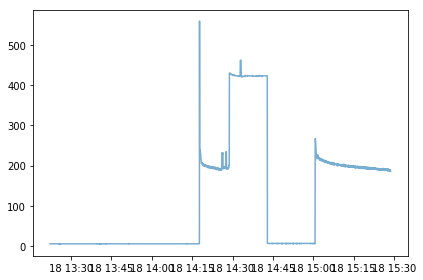

In [32]:
fig, ax = plt.subplots()
ax.plot(df[1]['refrigerator_5'][:2000], alpha = 0.6)
fig.tight_layout()

### From this part I will write DNN codes

In [1]:
print('test git merge')

test git merge
